# 第8章 循环神经网络

## 8.1 序列模型

### 练习 8.1.1

改进本节实验中的模型。
1. 是否包含了过去$4$个以上的观测结果？真实值需要是多少个？
1. 如果没有噪音，需要多少个过去的观测结果？提示：把$\sin$和$\cos$写成微分方程。
1. 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？
1. 改变神经网络架构并评估其性能。

**解答：**

1. 是否包含了过去4个以上的观测结果？真实值需要是多少个？

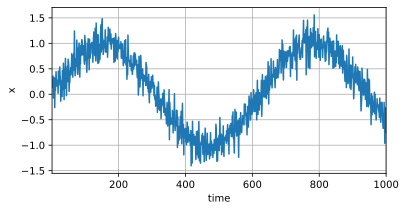

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点的时间范围
time = torch.arange(1, T + 1, dtype=torch.float32)        # 根据点生成时间序列
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))   # 按正弦函数生成序列x，并为其添加正态分布噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

&emsp;&emsp;$x = torch.sin(0.01 * time)$ 中乘 $0.01$ 的目的在于对时间序列进行缩放，以便更好的进行观察。未缩放的结果如下图所示。

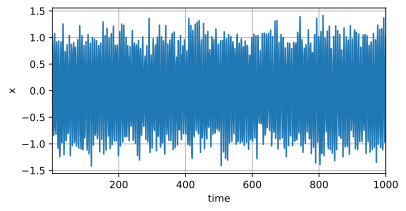

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点的时间范围
time = torch.arange(1, T + 1, dtype=torch.float32)        # 根据点生成时间序列
x = torch.sin(time) + torch.normal(0, 0.2, (T,))   # 按正弦函数生成序列x，并为其添加正态分布噪声
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [10]:
# 定义滞后步数
tau = 5
# 初始化特征矩阵，形状为(T - tau, tau)，用于存储滞后特征
features = torch.zeros((T - tau, tau))
for i in range(tau):
    # 将每个滞后步数对应的原始序列存储到特征矩阵中
    features[:, i] = x[i: T - tau + i]

# 生成标签，并对生成形状进行设置    
labels = x[tau:].reshape((-1, 1))
print(labels.shape)

# 设置训练批次与训练样本数
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

torch.Size([995, 1])


In [11]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(tau, 20),
                        nn.ReLU(),
                        nn.Linear(20, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [12]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)   # 设置Adam优化器
    for epoch in range(epochs):
        for X, y in train_iter:
            # 梯度清零
            trainer.zero_grad()
            # 计算MSELoss
            l = loss(net(X), y)
            # 进行求和并反向传播
            l.sum().backward()
            # 通过优化器进行参数更新
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()   # 加载定义好的网络模型
train(net, train_iter, loss, 5, 0.01)    # 调用train函数进行训练，训练5轮，学习率为0.01

epoch 1, loss: 0.059790
epoch 2, loss: 0.053361
epoch 3, loss: 0.056654
epoch 4, loss: 0.054220
epoch 5, loss: 0.049205


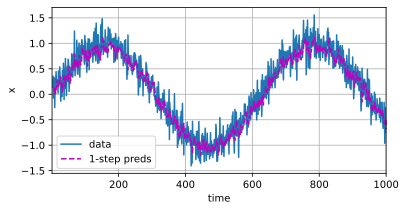

In [13]:
# 调用训练好的模型进行预测
onestep_preds = net(features)
# 纵轴为序列值x,横轴为时间，data为原始数据，1-step(单步预测):根据上一个过去值预测下一个值
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

&emsp;&emsp;在代码中，模型通过一个形状为$(T-tau, tau)$ 的特征张量存储过去观测结果，此时 $T$ 为总观测数，$tau$ 为观测结果的历史长度，将 $tau$ 设置为 $5$ 后，模型考虑了过去 $5$ 个观测结果作为滞后特征，即在当前时间点，模型在预测时考虑了过去5个时间点的观测结果。  
&emsp;&emsp;由于预测是基于单变量的时序预测，即根据过去观测结果预测下一时间步的值，因此在代码中，真实值存储在$(T-tau, 1)$的张量中，且在代码中使用 <code>lables=x[tau:].reshape((-1, 1))</code> 生成标签，因此真实值数量为总样本数减去滞后步数，即共有 $1000-5=995$ 个真实值

2. 如果没有噪音，需要多少个过去的观测结果？提示：把sin和cos写成微分方程

&emsp;&emsp;根据正余弦函数导数，存在
$$\displaystyle{\frac{d}{dx}sin(x)=cos(x)}$$
$$\displaystyle{\frac{d}{dx}cos(x)=-sin(x)}$$
&emsp;&emsp;因此$sin$与$cos$的导数可以相互表示，即可通过以下微分方程描述$sin$与$cos$二者间关系：
$$\displaystyle{\frac{dy}{dx}=cos(x)}$$
&emsp;&emsp;因此在没有噪声的情况下，由于可以对$sin$值和$cos$值通过微分互相计算，因此只需要一个过去观测结果就可通过微分方程来恢复未观测的值，得到完整信息。

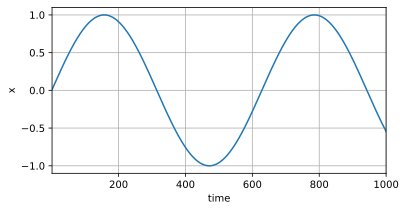

In [42]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [43]:
tau = 1
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [44]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.033229
epoch 2, loss: 0.005169
epoch 3, loss: 0.002071
epoch 4, loss: 0.001557
epoch 5, loss: 0.001237


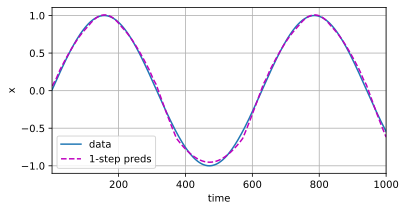

In [45]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

3. 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？

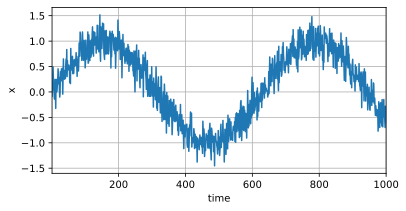

In [52]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [53]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(T - tau):
    features[i] = x[i:i+tau]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [54]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.064830
epoch 2, loss: 0.060723
epoch 3, loss: 0.057784
epoch 4, loss: 0.057198
epoch 5, loss: 0.054965


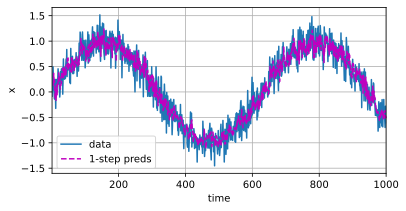

In [55]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

&emsp;&emsp;可以采用滑动窗口的方式生成特征矩阵**feature**，这种方式在原有特征矩阵中移动窗口的起始位置，并没有增加新的特征维度。通过利用过去的观察结果作为输入特征，通过合并旧的观察结果，可以提供更丰富的特征信息，使得模型可以捕捉到序列数据中的时间相关性，从而有效提高预测准确度。

4. 改变神经网络架构并评估其性能

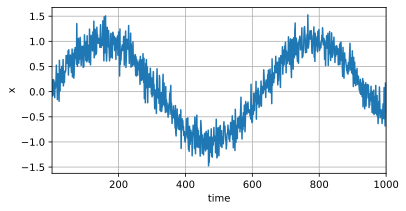

In [9]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [10]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [11]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [6]:
def new_get_net():
    net = nn.Sequential(nn.Linear(tau, 50),
                        nn.ReLU(),
                        nn.Linear(50, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

In [12]:
def train_draw(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    losses = []  # 用于记录每个 epoch 的损失值
    for epoch in range(epochs):
        epoch_loss = 0.0
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
            epoch_loss += l.mean().item()
        epoch_loss /= len(train_iter)
        losses.append(epoch_loss)
        print(f'epoch {epoch + 1}, loss: {epoch_loss:f}')

    # 绘制损失曲线
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

epoch 1, loss: 0.215900
epoch 2, loss: 0.065764
epoch 3, loss: 0.059391
epoch 4, loss: 0.056455
epoch 5, loss: 0.055573


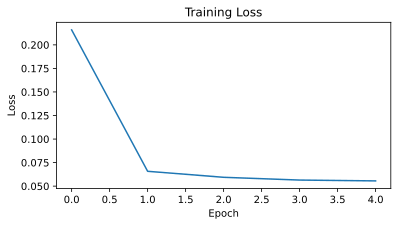

In [13]:
net_1 = get_net()
train_draw(net_1, train_iter, loss, 5, 0.01)

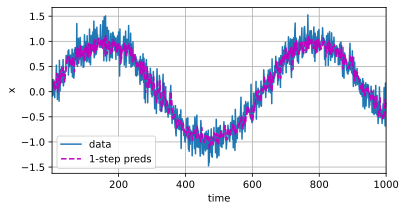

In [14]:
onestep_preds = net_1(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

epoch 1, loss: 0.125826
epoch 2, loss: 0.055088
epoch 3, loss: 0.059558
epoch 4, loss: 0.058091
epoch 5, loss: 0.053354


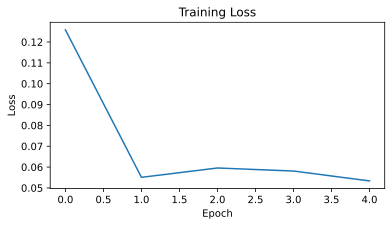

In [15]:
net_2 = new_get_net()
train_draw(net_2, train_iter, loss, 5, 0.01)

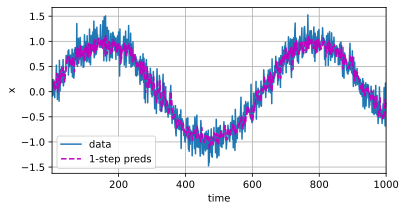

In [16]:
onestep_preds = net_1(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

&emsp;&emsp;通过增加多层感知机中隐藏层的大小和层数，可以发现loss相较于初始的多层感知机出现降低，说明复杂结构在某种程度上提升了模型性能，但是可以发现复杂结构的loss在第2个epoch出现增高，导致曲线振荡。

### 练习 8.1.2

一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？

**解答:**

&emsp;&emsp;该投资者仅采用过去的回报作为参考信息来预测未来的证券表现，属于外推法。  
&emsp;&emsp;外推法在预测未来数据时，存在假设局限性，即数据必须满足其过去历史可以用来预测未来的趋势。如果假设不成立，那么预测结果很可能会不准确。且外推法不能预测突发事件的发生，并且预测结果非常依赖数据质量。如果历史数据不准确，预测结果也会受到影响。   
&emsp;&emsp;对于金融证券来说，决定证券回报的因素不仅仅包括过去的回报曲线，还包括政治事件、行业趋势和金融危机等外部因素，而这些因素往往是决定证券表现的重要因素。因此在使用外推法预测证券未来回报时，很难考虑到随时变化的市场环境以及突发的外部因素，从而带来产生巨大误差。

### 练习 8.1.3

时间是向前推进的因果模型在多大程度上适用于文本呢？

**解答：**

&emsp;&emsp;时间是向前推进的因果模型是一种基于时间序列和因果关系的模型，该模型假设未来的结果受过去因素和时间序列影响，并且无法反过来影响过去因素。  
&emsp;&emsp;在文本数据中，对于按时间顺序排列的文本数据，如新闻报道、历史日志等，这些内容在理解和预测发展时，时间因素至关重要，可以更好的帮助模型去学习。因此在舆情分析、时序预测等与时间因素强相关的任务中，时间是向前推进的因果模型可以起到很大作用。  
&emsp;&emsp;但时间序列并非影响未来文本结果产生的唯一因素，在一些静态文本分类或情感分析任务中，文本本身可能足以进行准确的预测，而不需要考虑时间信息，此时时序与文本内容的产生并无显著关联。在这种情况下采用时间前向推进的因果模型并不能很好的适用于文本场景。需要通过建立更加复杂的模型来考虑影响文本内容的多种因素。  
&emsp;&emsp;因此在处理文本数据时，需要根据具体任务细节来评估时间因素对于任务的重要性，以此来选择合适的模型结构和特征工程方法。

### 练习 8.1.4

举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。

**解答：**

&emsp;&emsp;隐变量自回归模型是一种用于建模时间序列数据中的动态变化的自回归模型，该模型通过引入一些隐变量来捕捉数据的动态性质。  
&emsp;&emsp;动力学模型则是一种描述系统状态随时间变化而变化的数学模型，在该模型中，系统的状态可以用一组状态变量来表示，并且这些状态变量随着时间的推移而发生变化。  
&emsp;&emsp;因此，在实际场景中，股票价格变化通常受时间序列和市场因素的影响，可通过隐变量自回归模型自回归的建模股票在时间上的依赖关系，并通过隐变量来捕捉未观测到的市场信息，最终建立起股票价格的动力学模型。

## 8.2 文本预处理 

### 练习 8.2.1

词元化是一个关键的预处理步骤，它因语言而异。尝试找到另外三种常用的词元化文本的方法。

**解答：**

&emsp;&emsp;三种常用的词元化文本的方法如下：
1. BPE(Byte-Pair Encoding)：字节对编码，该方法本质是一种贪心算法，具体流程如下：
   - 在语料库中单词末尾添加 <code>\</w></code>，并统计该单词出现的次数
   - 将单词切分为单个字符作为子词，并以此构建出初始子词词表
   - 在语料库中，统计单词内相邻子词对的频数
   - 将频数最高的子词对合并为新的子词，并加入到子词词表中
   - 重复上述两步，直到达到合并次数或子词词表中所有子词的频数均为1。
   通过该方法，对语料库实现了数据压缩，实现通过最少的token数表示一个corpus

2. WordPiece：WordPiece与BPE方法类似，本质也是一种贪心，但是不同于BPE选择出现频率最高的两个子词合并为新的子词，WordPiece选择具有较强关联性的子词进行合并。具体流程如下：
   - 将语料库中单词切分为单个字符作为初始化的子词词表，假设每个子词独立，此时语言模型似然值等价于子词概率积
   - 两两拼接子词，并统计新子词加入词表后对语言模型似然值的提升程度
   - 最终选择对语言模型似然度提升最大的字符加入到词表中
   - 重复上述两步，直到词表大小达到指定大小。

3. SentencePiece：不同于BPE和WordPiece中采用空格区分不同单词的方式，SentencePiece将空格也进行编码，不考虑句子中单独的单词，而是将整个句子作为整体进行拆分。再通过BPE或Unigram的方式构造词表。

### 练习 8.2.2

在本节的实验中，将文本词元为单词和更改`Vocab`实例的`min_freq`参数。这对词表大小有何影响？

**解答：**

In [12]:
import collections
import re

import numpy as np
from d2l import torch as d2l

&emsp;&emsp;词元设置为Char时，输出的语料库和词表大小为 $(170580, 28)$，结果如下：

In [ ]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = d2l.read_time_machine()       # 获取时光机器数据集文本行的数据
    tokens = d2l.tokenize(lines, 'char')  # 对文本进行分词，将字符级转换为词元
    vocab = d2l.Vocab(tokens)             # 创建词汇表对象，将词元映射到索引
    
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    
    # max_tokens主要用于限制corpus长度
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    
    # 返回列表和词汇表
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
# 打印列表和词汇表大小
len(corpus), len(vocab)

In [ ]:
print(vocab.idx_to_token)

&emsp;&emsp;而当词元设置为Word时，输出的语料库和词表大小为 $(32775, 4580)$，结果如下：

In [ ]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = d2l.read_time_machine()
    tokens = d2l.tokenize(lines, 'word')
    vocab = d2l.Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

&emsp;&emsp;在本节实验中，Vocab 实例的 **min_freq** 参数主要用来实现对低频词的过滤，默认 **min_freq=0**，结果如下：

In [ ]:
lines = d2l.read_time_machine()
tokens = d2l.tokenize(lines, 'word')
vocab=d2l.Vocab(tokens, min_freq=0)

for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

&emsp;&emsp;设置 **min_freq=10**，过滤掉低频词，所得对词表的影响结果如下：

In [ ]:
vocab=d2l.Vocab(tokens, min_freq=10)

for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

&emsp;&emsp;可以看到，将文本词元从字符（Char）改为单词（Word）后，词表大小由28个字符扩大到4580个单词，语料内容也从根据字符划分变更为根据单词划分。  
&emsp;&emsp;<code>min_frep</code> 参数则是主要用于对低频词进行过滤，通过进一步过滤掉低频词减少词表大小，降低噪音影响，使得模型更加高效，有助于提高模型的学习效果。

## 8.3 语言模型和数据集

### 练习 8.3.1

假设训练数据集中有$100,000$个单词。一个四元语法需要存储多少个词频和相邻多词频率？

**解答：**

&emsp;&emsp;对于$100000$个单词，四元组需要存储每个单词的词频，即$P(W_i), i\in (1,100000)$，总计$100000$个。  
&emsp;&emsp;计算相邻多词频率时，由于二元组、三元组以及四元组构成的词不同，因此需要将每个元组构成的词进行存储，例如“The War of Worlds”，若想知道$P(\text{The War of Worlds})$的概率，需要知道$P(\text{The}),P(\text{War|The}),P(\text{of|The War}),P(\text{Worlds|The War of})$的概率。  
&emsp;&emsp;因此对于$100000$个单词，其二相邻频率为  
$$(1 \times 10^5)^2$$
&emsp;&emsp;三相邻频率为  
$$(1 \times 10^5)^3$$
&emsp;&emsp;四相邻频率为  
$$(1 \times 10^5)^4$$
&emsp;&emsp;共需要存储$1 \times 10^{10}+1 \times 10^{15} + 1 \times 10^{20}$个相邻多词频率。  

### 练习 8.3.2

我们如何对一系列对话建模？

**解答:**

&emsp;&emsp;N-Gram语法将文本看作一系列的词序列，假设当前词的出现概率与前$N-1$个词相关，根据出现的频率来估计下一个词出现的概率。因此对于对话建模问题，理论上可以将对话中的每个句子看作一个独立的文本序列，并对每个文本序列计算出对应的词频和N-Gram概率，在预测下一个词时，将前$N-1$个词视作上下文，选择出现概率最高的词作为下一个词。重复上述过程，直到生成整个对话。  
&emsp;&emsp;但是N-Gram对于长距离的依赖关系并不能处理的很好，因此将对话语句处理为独立文本序列后，还可以采用RNN或LSTM进行建模。

In [ ]:
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter, defaultdict

# 读取对话数据
dialogues = [
    "Hi,how are you?",
    "I'm fine, thank you. And you?",
    "I'm good too.",
    "That's great!",
    "Thanks.",
]

# 将对话数据转换为词序列
tokens = []
for dialogue in dialogues:
    tokens += word_tokenize(dialogue)

# 统计词频
word_freq = Counter(tokens)

# 将word_freq字典的键的默认值设置为1
default_freq = 1
word_freq = defaultdict(int, {k: v for k, v in word_freq.items()})   # 创建默认字典
word_freq.default_factory = lambda: default_freq                     # 若访问不存在的键时，返回default_frep以避免KeyError

# 计算N-gram概率
n = 3 # 选择3-gram模型
ngrams_freq = Counter(ngrams(tokens, n))
ngrams_prob = {}
for ngram in ngrams_freq:
    context = ' '.join(ngram[:-1])      # 将前n-1个词连接，组成context
    if context not in ngrams_prob:
        # 若上下文内容不存在于字典中，则添加空字典作为条目
        ngrams_prob[context] = {}
        
    # 计算当前N_gram的条件概率    
    ngrams_prob[context][ngram[-1]] = ngrams_freq[ngram] / word_freq[context]

# 使用N-gram模型生成对话
start = 'Hi,'
dialogue = [start]
for i in range(10):
    context = ' '.join(dialogue[-n+1:])
    if context in ngrams_prob:
        next_word = max(ngrams_prob[context], key=ngrams_prob[context].get)
    else:
        next_word = max(word_freq, key=word_freq.get)
    dialogue.append(next_word)
print(' '.join(dialogue))

### 练习 8.3.3

一元语法、二元语法和三元语法的齐普夫定律的指数是不一样的，能设法估计么？

**解答：**

&emsp;&emsp;齐普夫定律认为，排名与频率之间存在的负相关的关系。即对于大规模文本，将其中每个词的词频进行统计，并由高到低排序标号，则这些单词的频数$F$和这些单词的序号$R$之间存在一个常数$C$，满足$F \times R=C$，以"The Time Machine" 这篇文章为例，其各语法的齐普夫定律指数如下：

In [ ]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)

freqs = [freq for token, freq in vocab.token_freqs]

bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# 一元语法的齐普夫定律指数
zipf_one = [freq * (i+1) for i, freq in enumerate(freqs[:6])]

# 二元语法的齐普夫定律指数
zipf_two = [freq * (i+1) for i, freq in enumerate(bigram_freqs[:6])]

# 三元语法的齐普夫定律指数
zip_three = [freq * (i+1) for i, freq in enumerate(trigram_freqs[:6])]

# 绘制图像
d2l.plot([zipf_one, zipf_two, zip_three],
         xlabel='token: x',ylabel='zipf',
         xscale='log', yscale='log',
         legend=['zipf_one', 'zipf_two', 'zipf_three'])

### 练习 8.3.4

想一想读取长序列数据的其他方法？

**解答：**

&emsp;&emsp;在读取长序列数据时，除了随机采样和顺序分区，还可以采用下列方法：
- 滑动窗口：通过滑动窗口，可以将一个长序列拆分为若干等长的有重叠子序列，在BERT中，这些子序列会被当做单独的文本进行处理，然后将所有子序列的输出结果进行整合，获得最终的长文本序列处理结果。
- 分层采样：将整个长序列先拆分为不同层次，使得每个层次包含不同的序列信息，通过这种方法，既可以保留长序列中的上下文信息，也可对整个长序列进行多层次的抽象概括。

### 练习 8.3.5

考虑一下我们用于读取长序列的随机偏移量。
1. 为什么随机偏移量是个好主意？
1. 它真的会在文档的序列上实现完美的均匀分布吗？
1. 要怎么做才能使分布更均匀？

**解答：**

1. 为什么随机偏移量是个好主意？

&emsp;&emsp;书中介绍到：  
> 由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。 在$8.1$节中我们以一种相当特别的方式做到了这一点： 当序列变得太长而不能被模型一次性全部处理时， 我们可能希望拆分这样的序列方便模型读取。  
> 由于文本序列可以是任意长的， 例如整本《时光机器》（The Time Machine）， 于是任意长的序列可以被我们划分为具有相同时间步数的子序列。 当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。  

&emsp;&emsp;因此在划分序列时，需要设置一个偏移量，从偏移量的位置开始划分序列。  
&emsp;&emsp;如果固定偏移量，则会导致迭代后，每次迭代所获取到的子序列均只覆盖有限的序列范围，无法保证全部序列的覆盖性。  

In [ ]:
my_seq = list(range(35))

def seq_data_iter(corpus, batch_size, num_steps):  #@save
    """使用固定偏移量生成一个小批量子序列"""
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

for i in range(10):
    print('i=',i)
    for X, Y in seq_data_iter(my_seq, batch_size=2, num_steps=5):
        print('X: ', X, '\nY:', Y)

&emsp;&emsp;加入随机偏移量后，每次迭代时从不同初始位置获取的子序列，既保证了覆盖性，也保证了随机性。

In [ ]:
import random

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

for i in range(10):
    print('i=',i)
    for X, Y in d2l.seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
        print('X: ', X, '\nY:', Y)

2. 它真的会在文档的序列上实现完美的均匀分布吗？

&emsp;&emsp;长序列采样时，通过为每个采样点加入随机偏移量可以在一定程度上增加子序列的覆盖性和随机性，但是并不能实现完美的均匀分布，因为加入偏移量后无法保证每个采样点的采样概率完全相等，偏移量的存在可能会使得某些子序列被频繁采样，某些子序列被跳过。

3. 要怎么做才能使分布更均匀？

&emsp;&emsp;一方面，可以采用多次采样后取均值的方法来缓解随即偏移量带来的采样偏差问题。另一方面，也可以降低随即偏移量的大小，使得采样点间的距离更加均匀，以此来提高采样均匀性。

### 练习 8.3.6

如果我们希望一个序列样本是一个完整的句子，那么这在小批量抽样中会带来怎样的问题？如何解决？

**解答：**

&emsp;&emsp;采用小批量采样时，通常会在序列中随机选取采样点位置，从而导致整个句子的完整性被破坏，并且这种切断方式还会破坏句子间的上下文关系，使得模型无法理解句子结构。  
&emsp;&emsp;解决这种问题，需要采取措施避免句子序列被截断，以及上下文关系被破坏。例如可以采取手动控制采样位置的方式，确定句子边界后，将边界处设置为采样点。或者增加序列长度，确保长句不会被切断，保留更多的完整句子。

## 8.4 循环神经网络 

### 练习 8.4.1

如果我们使用循环神经网络来预测文本序列中的下一个字符，那么任意输出所需的维度是多少？

**解答：**

&emsp;&emsp;根据循环神经网络中隐藏层与输出层计算公式：
$$H_t = \phi(X_tW_{xh}+H_{t-1}W_{hh}+b_h)$$
$$O_t = H_tW_{hq}+b_q$$
&emsp;&emsp;再参考原书中内容：
> 循环神经网络的参数包括隐藏层的权重$W_{xh} \in \mathbb{R}^{d \times h},W_{hh} \in \mathbb{R}^{h \times h}$和偏置$b_h \in \mathbb{R}^{1 \times h}$，以及输出层的权重$W_{hq} \in \mathbb{R}^{h \times q}$和偏置$b_q \in \mathbb{R}^{1 \times q}$。

&emsp;&emsp;结合上述内容可知，在循环神经网络中，当前时间步计算得到的隐藏层一方面会作为下一时间步的输入，另一方面会输入到全连接层中用于计算当前时间步的输出，因此输出结果的维度受当前时间步隐状态的维度以及输出层权重维度的共同影响。  
&emsp;&emsp;对于文本序列，需要采用One-hot编码将每个单词映射为特征向量，因此对于一个批量大小为$n$，时间步为$d$的$n \times d$维采样数据，经过one-hot编码后转换为三维张量（时间步，批量大小，词表大小），假设词表大小为$l$，此时循环神经网络的输入维度为$(d \times n \times l)$。这样的目的是更方便的通过最外围的时间步数去一步步更新数据。因此在每个时间步中，输入维度为$n \times l$，根据矩阵乘法计算可得，隐状态$H_t$的维度为：
$$(n \times l) \times (l \times h) = n \times h$$
&emsp;&emsp;输出结果$O_t$的维度为：
$$(n \times h) \times (h \times q) = n \times q$$
&emsp;&emsp;这里为了方便计算，忽略了偏置$b_h,b_q$，并且在预测文本序列中下一个字符时，由于该字符来自同一个词表，因此$q$为词表长度，即满足$q = l$。  
&emsp;&emsp;所以对于每个时间步，在训练循环神经网络时，由于输入和输出均来自于同一个文本序列，模型的输入和输出需要来自相同的词表，因此它们具有相同的维度。

&emsp;&emsp;代码实现如下：

In [ ]:
import torch
import torch.nn as nn
from d2l import torch as d2l
from torch.nn import functional as F
import numpy as np
# 设置批量大小与时间步
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# 初始化输入
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

In [ ]:
# 初始化参数与RNN模型
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    # 将List中的每个Y组合，输出维度
    Y_list = torch.stack(outputs)
    print('Y_list.shape:', Y_list.shape)
    return torch.cat(outputs, dim=0), (H,)

class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        # 打印转换后的X的维度
        print('X.shape:', X.shape)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [ ]:
# 打印输出形状
num_hiddens = 256
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
print('state.shape:', new_state[0].shape)
# Y.shape, new_state[0].shape

### 练习 8.4.2

为什么循环神经网络可以基于文本序列中所有先前的词元，在某个时间步表示当前词元的条件概率？

**解答：**

&emsp;&emsp;RNN实际上是一种递归循环神经网络，即在每个时间步接收输入和前一时间步的隐藏状态，并输出当前时间步的隐藏状态。这种结构使得RNN能够捕捉序列数据中的时间依赖关系，令先前的信息得以传递到后续的时间步。  
&emsp;&emsp;因为RNN的隐藏状态中包含了模型对过去所有输入信息的表示，因此在每个时间步进行更新时，RNN的隐藏状态也会随之更新，使得当前输入与上一步的隐藏状态进行结合，形成新的隐藏状态。因此RNN在处理文本序列时，可以根据隐藏状态内的历史上下文信息来增强对当前词元的理解。  
&emsp;&emsp;通过不断更新隐藏状态并传递历史信息，RNN可以在某个时间步对当前词元进行建模，并输出当前词元的条件概率这使得RNN能够更好地理解文本序列中词与词之间的长期依赖关系，有助于更准确地预测或生成序列中的下一个词。

### 练习 8.4.3

如果基于一个长序列进行反向传播，梯度会发生什么状况？

**解答：**

&emsp;&emsp;基于长序列进行反向传播时，假设序列长度为$\text{T}$，则迭代计算$\text{T}$个时间步的梯度时，会产生长度为$O(T)$的矩阵乘法链，造成类似多层感知机中层数为$\text{T}$的情况，因此当序列长度过长时，会使得梯度值在反向传播进行梯度累乘时放大或缩小梯度值，使得梯度值出现指数级的放大或衰减，导致数值不稳定，出现梯度爆炸或者梯度消失等现象。

**解答：**

&emsp;&emsp;基于长序列进行反向传播时，假设序列长度为$\text{T}$，则迭代计算$\text{T}$个时间步的梯度时，会产生长度为$O(T)$的矩阵乘法链，造成类似多层感知机中层数为$\text{T}$的情况，因此当序列长度过长时，会使得梯度值在反向传播进行梯度累乘时放大或缩小梯度值，使得梯度值出现指数级的放大或衰减，导致数值不稳定，出现梯度爆炸或者梯度消失等现象。

### 练习 8.4.4

与本节中描述的语言模型相关的问题有哪些？

**解答：**

&emsp;&emsp;循环神经网络常被用来处理序列问题，具体应用场景如下：
- 文本生成：根据给定文本序列内容预测下一个词的生成。
- 文本分类：根据给定序列内容，在最后输出序列类型（情感分析）
- 机器翻译：将给定的文本序列全部输入完成之后，对文本序列进行翻译，转换为另一种语言

## 8.5 循环神经网络的从零开始实现 

### 练习 8.5.1

尝试说明独热编码等价于为每个对象选择不同的嵌入表示。

**解答：**

&emsp;&emsp;独热（one-hot）编码是对每个对象都用一个长度等于对象总数的向量来表示。每个向量的所有元素都是零，只有与对象对应的索引处的元素是1，表示该对象的存在。  
&emsp;&emsp;嵌入表示（embedding）是用固定大小的稠密向量表示对象，每个对象都与唯一的嵌入向量关联。  
&emsp;&emsp;如果我们考虑一组对象的独热编码，每个对象将有一个唯一的二进制向量。类似地，如果我们考虑同一组对象的嵌入表示，每个类别将有一个唯一的稠密向量。当假设嵌入表示向量和独热编码向量维度相同时，独热编码可以等价于为每个对象选择了不同的嵌入表示。

### 练习 8.5.2

通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。
1. 困惑度可以降到多少？
2. 用可学习的嵌入表示替换独热编码，是否会带来更好的表现？
3. 如果用H.G.Wells的其他书作为数据集时效果如何，例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？

**解答：**

1.困惑度可以降到多少？

&emsp;&emsp;困惑度常用来对语言模型好坏进行评估，其公式如下：
$$\text{perplexity} = exp\bigg(- \displaystyle{\frac{1}{n} \sum_{t=1}^n \log P(x_t|x_{t-1},...,x-1)} \bigg)$$
&emsp;&emsp;在最好的情况下，模型可以完美估计标签词元的概率为1，此时困惑度为1；而模型正确预测标签词元的概率为0时，这种最坏情况下的困惑度为无穷大。

&emsp;&emsp;定义多种超参数组合：

In [1]:
from d2l import torch as d2l
import torch
from torch import nn

In [2]:
# [迭代周期，隐藏单元数，批量大小，小批量数据时间步数，学习率]
hyper_1 = [250, 512, 35, 10, 1]
hyper_2 = [500, 512, 35, 32, 1]
hyper_3 = [500, 128, 10, 10, 1]
hyper_4 = [1000, 256, 10, 32, 0.01]
hyper_params = [hyper_1, hyper_2, hyper_3, hyper_4]

In [3]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    # animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
    #                         legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
        # if (epoch + 1) % 10 == 0:
        #     animator.add(epoch + 1, [ppl])
    return ppl
#     print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
#     print(predict('time traveller'))
#     print(predict('traveller'))

In [4]:
perplexity = []
for i in range(len(hyper_params)):
    num_epochs, num_hiddens, batch_size, num_steps, lr = hyper_params[i]
    train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
    net = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)
    value = round(train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu()), 1)
    perplexity.append(value)
    print('hyper[%d]:%.1f'%(i,perplexity[i]))

hyper[0]:1.1
hyper[1]:1.0
hyper[2]:2.9
hyper[3]:8.6


2.用可学习的嵌入表示替换独热编码，是否会带来更好的表现？

&emsp;&emsp;若采用可学习嵌入表示对one-hot编码进行替换，会带来更好的表现，因为可学习的嵌入表示可以将相似近义词映射到相似嵌入向量中，而不是one-hot中相互独立的向量基。  
&emsp;&emsp;这种做法可以使得语义信息得到更好的表示，令神经网络能够更好地学习其类别相似性关系。

perplexity 1.3, 389210.1 tokens/sec on cuda:0
time travellerit wiscovers he os the thing theef tishelding but 
traveller ffron wh the gemman scadimed for the historian th


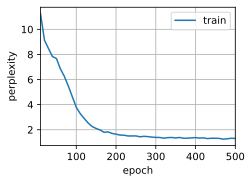

In [2]:
# one-hot编码
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 1.1, 389214.2 tokens/sec on cuda:0
time travellerit s against reaiont of the barometer yesterday ni
traveller with a slight night of hand trick or other said t


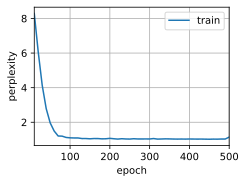

In [3]:
# 可学习嵌入表示
class RNNModel_Embedding(nn.Module):
    def __init__(self, rnn_layer, vocab_size, embedding_dim, **kwargs):
        super(RNNModel_Embedding, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = self.embedding(inputs.T.long())
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)
device = d2l.try_gpu()
embedding_dim = 28
net = RNNModel_Embedding(rnn_layer, vocab_size=len(vocab), embedding_dim=embedding_dim)
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

3.如果用H.G.Wells的其他书作为数据集时效果如何，例如[*世界大战*](http://www.gutenberg.org/ebooks/36)？

&emsp;&emsp;相较于“时间机器”数据集，更换数据集后，文本数据量明显增加，最终预测结果更好。

perplexity 1.0, 358077.6 tokens/sec on cuda:0
time traveller wewe haid the ract of itimets hemise of thet in s
travellerd in the reaner the nlatlo sia senrry ou the cling


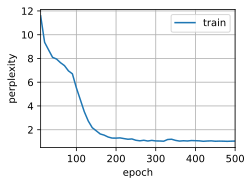

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import re

def read_world():
    with open('../../notebooks/data/the war of the worlds.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def load_corpus_world(max_tokens=-1):  #@save
    """返回世界大战数据集的词元索引列表和词表"""
    lines = read_world()
    tokens = d2l.tokenize(lines, 'char')
    vocab = d2l.Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        """Defined in :numref:`sec_language_model`"""
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_world(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_world(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset.

    Defined in :numref:`sec_language_model`"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_world(batch_size, num_steps)
num_hiddens = 512
rnn_layer = nn.RNN(len(vocab), num_hiddens)

device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.5.3

修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。
1. 会发生什么？
2. 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。

**解答：**

1. 会发生什么？

&emsp;&emsp;改为采样方式后，每次生成文本时都以一定概率选择不同字符，导致文本在生成时的随机性大大增加，提高了多样性，但是也导致生成文本更加不稳定，出现困惑度爆炸的情况。

In [12]:
from d2l import torch as d2l
import torch
from torch import nn

In [40]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """使用采样方式在前缀之后生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        # 使用 softmax 和采样获取下一个字符
        next_char = torch.multinomial(F.softmax(y, dim=1).reshape(-1), num_samples=1).reshape(1)
        outputs.append(int(next_char))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [42]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1250491106139826552832.0, 372926.9 词元/秒 cuda:0
time traveller to toto to toto to toto to toto to toto to toto t
traveller tota to toto to toto to toto to toto to toto to t


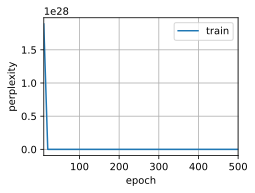

In [43]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
num_hiddens = 512
rnn_layer = nn.RNN(len(vocab), num_hiddens)

device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

2. 调整模型使之偏向更可能的输出，例如，当$\alpha > 1$，从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中采样。

&emsp;&emsp;从$q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$中进行采样，较大的$\alpha$会使得概率较高的字符更容易被选择，以此选择概率较高的字符作为输出。这种方法降低了生成文本的多样性，但同时也使得输出结果更加稳定，困惑度更低。

In [50]:
def predict_ch8_alpha(prefix, num_preds, net, vocab, device, alpha=1.0):
    """使用采样方式在前缀之后生成新字符，应用指数变换"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        probabilities = F.softmax(y, dim=1).reshape(-1)
        probabilities = probabilities ** alpha  # 应用指数变换
        probabilities = probabilities / probabilities.sum()  # 归一化概率
        next_char = torch.multinomial(probabilities, num_samples=1).reshape(1)
        outputs.append(int(next_char))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [51]:
def train_ch8_alpha(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8_alpha(prefix, 50, net, vocab, device, alpha=10.0)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 372989.8 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


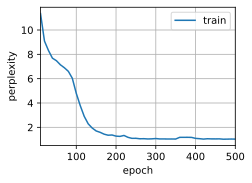

In [52]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
num_hiddens = 512
rnn_layer = nn.RNN(len(vocab), num_hiddens)

device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs, lr = 500, 1
train_ch8_alpha(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.5.4

在不裁剪梯度的情况下运行本节中的代码会发生什么？

**解答：**

&emsp;&emsp;根据原文内容的说明：
> 对于长度为$\text{T}$的序列，我们在迭代中计算这$\text{T}$个时间步上的梯度，将会在反向传播过程中产生长度为$O(T)$的矩阵乘法链。当$\text{T}$较大时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，循环神经网络模型往往需要额外的方式来支持稳定训练。

&emsp;&emsp;因此在不裁剪梯度的情况下，会出现数值不稳定的现象。相较于裁剪梯度，模型在训练时的困惑度曲线出现了波动，导致曲线出现不平滑的现象，且难以收敛。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import math

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

困惑度 2959885842715423132103179432897705889003535188623360.0, 447600.2 词元/秒 cuda:0
time travelleroooooooooooooooooooooooooooooooooooooooooooooooooo
travelleroooooooooooooooooooooooooooooooooooooooooooooooooo


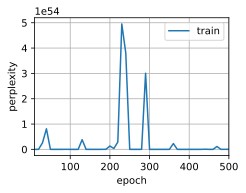

In [2]:
# 不裁剪梯度
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            # grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 1.3, 389210.1 tokens/sec on cuda:0
time travelleryou can anow thr ead hes thee in al with re we the
traveller bat lightyong on the bedican mpressiot ex rave yo


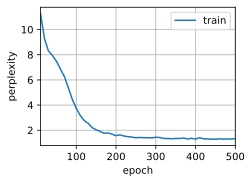

In [2]:
# 裁剪梯度
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.5.5

更改顺序划分，使其不会从计算图中分离隐状态。运行时间会有变化吗？困惑度呢？

**解答：**

&emsp;&emsp;先对输入和标签进行设备（device）变换和形状（reshape）变换，再进行前向计算和反向传播，将隐状态的分离操作放在更新之前，避免了更新中对隐状态进行计算，这样无需对隐状态进行修改，即可实现了不会从计算图中分离隐状态。  
&emsp;&emsp;通过实验知，这样的修改加快了词元速度，使得运行时间得到了减少，但困惑度也随之增加。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 100
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

perplexity 1.3, 516546.5 tokens/sec on cuda:0
time traveller but now you begin to seethe object of my investig
traveller curechis bovenis teomedomo gemmating that is must


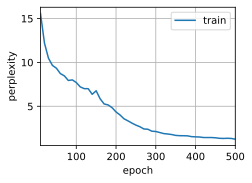

In [2]:
# 修改前
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [5]:
# 修改后
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        X, Y = X.to(device), Y.to(device)
        y = Y.T.reshape(-1)
        state = net.begin_state(batch_size=X.shape[0], device=device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward(retain_graph=True)
            d2l.grad_clipping(net, 1)
            updater.step()
        else:
            l.backward(retain_graph=True)
            d2l.grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.4, 564177.1 词元/秒 cuda:0
time traveller smiled are you sure we can move freely inspace ri
travelleris thing ber way f lo heve treef lere whon anofit 


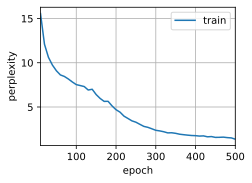

In [6]:
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.5.6

用ReLU替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？

**解答：**

&emsp;&emsp;原始RNN中采用tanh作为激活函数，tanh在输入很大或很小时，导数几乎为0，累乘会导致梯度消失。  
&emsp;&emsp;ReLU作为激活函数时，在输入为正时，梯度恒为1，在一定程度上ReLU缓解了梯度消失或爆炸，但由于梯度计算除了激活函数导数外，还包括权重连乘，并没有彻底解决梯度消失或爆炸问题。此外，ReLU在输入为负时，梯度恒为0，会导致一部分神经元未激活。  
&emsp;&emsp;此处，ReLu作为激活函数，会缓解反向传播时出现数值不稳定的现象，可以不进行梯度裁剪。但一般仅ReLU作为激活函数这一方法，并替代不了梯度裁剪解决梯度消失或爆炸问题。

In [1]:
# 更换为ReLU
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            # grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: d2l.predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.3, 157050.0 词元/秒 cuda:0
time traveller held in his hand was a flen the prover assimilati
traveller a len the time traveller held in his hand was a f


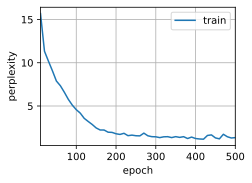

In [4]:
num_hiddens = 256
net = d2l.RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,init_rnn_state, rnn)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

## 8.6 循环神经网络的简洁实现 

### 练习 8.6.1

尝试使用高级API，能使循环神经网络模型过拟合吗？

**解答：**

&emsp;&emsp;在高级API中，针对循环神经网络进行了一系列优化，例如nn.RNN源码中增加了可开启的dropout模块，这些措施均可以很好的缓解模型在训练时的过拟合问题。  
&emsp;&emsp;但是设置不合理的参数，仍可使得模型过拟合，例如对于小的训练集，设置大的模型规模，如当隐藏单元数是1024，隐层数是3时，训练集上模型很快降到困惑度为1，但这并不意味着此处模型预测性能很好，而是发生了过拟合。

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

num_hiddens = 1024
num_layers = 3
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers=num_layers)

perplexity 1.0, 25271.1 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


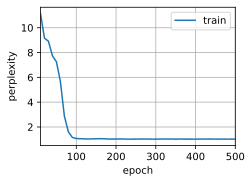

In [25]:
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.6.2

如果在循环神经网络模型中增加隐藏层的数量会发生什么？能使模型正常工作吗？

**解答：**

&emsp;&emsp;增加隐藏层的数量会使得模型变得更加复杂，一定程度上可以提高模型预测效果，但过于复杂的模型也会导致出现过拟合现象。当隐藏层更多时，模型训练难以收敛，发生欠拟合。例如将隐藏层由1增加到3，相较于单层隐藏层，模型的困惑度由1.2降低到1，而增加到20层时，模型困惑度训练完后反倒是17.4。同时，更多的隐藏层，token的生成速度也出现了明显下降。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 100
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [8]:
# 隐藏层为 1
num_hiddens = 256
num_layers = 1
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers=num_layers)

perplexity 1.2, 564185.0 tokens/sec on cuda:0
time traveller but now you begin to seethe object of my investig
travellerif the time traveller with a slight accession of h


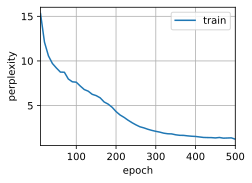

In [9]:
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

In [10]:
# 隐藏层为 3
num_hiddens = 256
num_layers = 3
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers=num_layers)

perplexity 1.0, 188061.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller for so it will be convenient to speak of himwas e


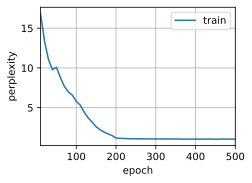

In [11]:
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

&emsp;&emsp;增加隐藏层数到20时，训练速度出现明显下降，且模型无法收敛，发生欠拟合。

In [2]:
# 隐藏层为20
num_hiddens = 256
num_layers = 20
rnn_layer = nn.RNN(len(vocab), num_hiddens, num_layers=num_layers)

perplexity 17.4, 29693.7 tokens/sec on cuda:0
time traveller                                                  
traveller                                                  


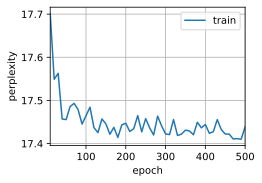

In [3]:
device = d2l.try_gpu()
net = d2l.RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

### 练习 8.6.3

尝试使用循环神经网络实现8.1节中的自回归模型。

**解答：**

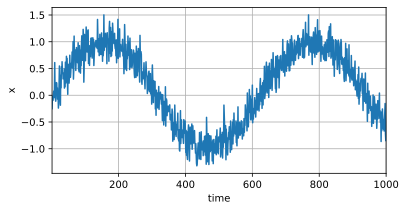

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [2]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        rnn_out, _ = self.rnn(input.view(len(input), 1, -1))
        output = self.linear(rnn_out.view(len(input), -1))
        return output

In [4]:
input_size = 4
hidden_size = 200
output_size = 1
learning_rate = 0.01
epochs = 50

In [5]:
model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
print(model)

RNN(
  (rnn): RNN(4, 200)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)


In [6]:
def train(model, train_iter, loss, epochs, learning_rate):
    trainer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            trainer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

In [7]:
train(model, train_iter, criterion, 50, 0.01)

Epoch [1/50], Loss: 0.1340
Epoch [2/50], Loss: 0.4435
Epoch [3/50], Loss: 0.1868
Epoch [4/50], Loss: 0.0468
Epoch [5/50], Loss: 0.0569
Epoch [6/50], Loss: 0.1126
Epoch [7/50], Loss: 0.1334
Epoch [8/50], Loss: 0.0951
Epoch [9/50], Loss: 0.0354
Epoch [10/50], Loss: 0.0208
Epoch [11/50], Loss: 0.1238
Epoch [12/50], Loss: 0.1387
Epoch [13/50], Loss: 0.1084
Epoch [14/50], Loss: 0.0657
Epoch [15/50], Loss: 0.0962
Epoch [16/50], Loss: 0.1152
Epoch [17/50], Loss: 0.0839
Epoch [18/50], Loss: 0.2132
Epoch [19/50], Loss: 0.1538
Epoch [20/50], Loss: 0.0813
Epoch [21/50], Loss: 0.2342
Epoch [22/50], Loss: 0.0403
Epoch [23/50], Loss: 0.0108
Epoch [24/50], Loss: 0.0898
Epoch [25/50], Loss: 0.1500
Epoch [26/50], Loss: 0.0687
Epoch [27/50], Loss: 0.0735
Epoch [28/50], Loss: 0.0599
Epoch [29/50], Loss: 0.0931
Epoch [30/50], Loss: 0.0552
Epoch [31/50], Loss: 0.0355
Epoch [32/50], Loss: 0.1011
Epoch [33/50], Loss: 0.1452
Epoch [34/50], Loss: 0.1631
Epoch [35/50], Loss: 0.0355
Epoch [36/50], Loss: 0.1047
E

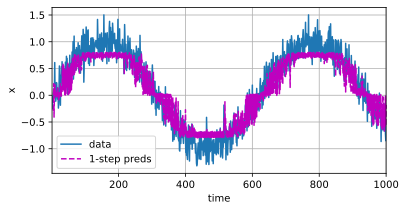

In [8]:
onestep_preds = model(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

## 8.7 通过时间反向传播 

### 练习 8.7.1

假设我们拥有一个对称矩阵$\mathbf{M} \in \mathbb{R}^{n \times n}$，其特征值为$\lambda_i$，对应的特征向量是$\mathbf{v}_i$（$i = 1, \ldots, n$）。通常情况下，假设特征值的序列顺序为$|\lambda_i| \geq |\lambda_{i+1}|$。
   1. 证明$\mathbf{M}^k$拥有特征值$\lambda_i^k$。
   1. 证明对于一个随机向量$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{M}^k \mathbf{x}$将有较高概率与$\mathbf{M}$的特征向量$\mathbf{v}_1$在一条直线上。形式化这个证明过程。
   1. 上述结果对于循环神经网络中的梯度意味着什么？

**解答：**

1.证明$\mathbf{M}^k$拥有特征值$\lambda_i^k$。

&emsp;&emsp;首先，由于$M$是对称矩阵，它可以被对角化为:
$$M = PDP^{-1}$$
&emsp;&emsp;其中，$P$ 是包含$M$的特征向量的矩阵，而$D$是对角矩阵，其对角线上的元素是$M$的特征值。  
&emsp;&emsp;现在，考虑$M^k$，我们有：
$$M^k = (PDP^{-1})^k = PD^kP^{-1}$$
&emsp;&emsp;$D^k$是对角矩阵，其对角线上的元素是$M$的特征值$\lambda$的$k$次方$\lambda^k$。因此，我们可以得到：
$$D^k = \begin{bmatrix} \lambda_1^k & 0 & \cdots & 0 \\ 0 & \lambda_2^k & \cdots & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \cdots & \lambda_n^k \end{bmatrix}$$
&emsp;&emsp;其中，$\lambda_i$是$M$的第$i$个特征值。  
&emsp;&emsp;最后，我们得到$M^k$的对角化形式：
$$M^k = PD^kP^{-1}$$
&emsp;&emsp;这意味着矩阵$M^k$与矩阵$M$具有相同的特征向量，而其特征值是$M$的特征值$\lambda$的$k$次方$\lambda^k$。因此，我们证明了如果$\lambda$是$M$的特征值，那么$\lambda^k$就是$M^k$的特征值。

2.证明对于一个随机向量$\mathbf{x} \in \mathbb{R}^n$，$\mathbf{M}^k \mathbf{x}$将有较高概率与$\mathbf{M}$的特征向量$\mathbf{v}_1$在一条直线上。形式化这个证明过程。

&emsp;&emsp;对于随机向量$x \in R^n$，可将其分解到特征向量$V$所在的向量空间中，即对于分解系数$\alpha_i$，存在分解式：
$$x = \alpha_1 v_1+\alpha_2 v_2+ ... + \alpha_n v_n = \sum_{i=1}^n \alpha_i v_i$$
&emsp;&emsp;将上述公式两边同乘$M^k$，存在：
$$\begin{align}
M^k \cdot x
&= \lambda_i^k \cdot x \\
&= \lambda_i^k \cdot \sum_{i=1}^n \alpha_i v_i \\
&= \sum_{i=1}^n \lambda_i^k \alpha_i v_i
\end{align}$$
&emsp;&emsp;又因为$M$的特征值$\lambda_i$满足$|\lambda_i| \geq |\lambda_{i+1}|$，因此$\lambda_1^k$指数级最大，即$v_1$的权重最大。  
&emsp;&emsp;因此$M^k \cdot x \approx \lambda_1^k \alpha_1 v_1$，即存在较高概率与特征向量$v_1$在一条直线上。

3.上述结果对于循环神经网络中的梯度意味着什么？

&emsp;&emsp;可将上述公式中的$M^k$理解为权重矩阵，当循环神经网络中，权重矩阵的特征向量与输入向量满足：
$$M \cdot x = \lambda_1 \alpha_1 v_1$$
&emsp;&emsp;其中$\alpha$根据$x$在特征向量$v$上投影的大小所决定，$\alpha$的变化会导致权重矩阵的变化，进而使得其在反向传播时的梯度受到影响。  
&emsp;&emsp;这种变化会随着序列长度的增加不断加剧，使得梯度不断放大或缩小，导致梯度爆炸或梯度消失的问题。

### 练习 8.7.2

除了梯度截断，还有其他方法来应对循环神经网络中的梯度爆炸吗？

**解答：**

&emsp;&emsp;除了进行梯度截断，还可采用下述方法解决循环神经网络中的梯度爆炸：
- 长短期记忆网络：可以通过引入门控机制或注意力机制的方法，减少梯度异常发生的概率，对循环神经网络进行改进。
- 对权重进行正则化，通过添加L1或L2正则项减少梯度爆炸发生的概率
- 修改激活函数，将激活函数更换为ReLU，可以有效减缓梯度爆炸问题
- 使用批次归一化（Batch Normalization）